1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [3]:
y = df['cardio']
X = df.drop('cardio', axis=1)

In [4]:
y.shape

(70000,)

In [5]:
X.shape

(70000, 12)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [8]:
from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [9]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.38817489, -0.5308834 , -0.70816849, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.30846829,  0.32314728, -0.63861364, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.34652706, -0.5308834 , -0.56905879, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.67245587,  0.56715605, -0.01261999, ...,  0.        ,
         0.        ,  1.        ],
       [-0.49851342,  0.32314728, -0.29083939, ...,  0.        ,
         0.        ,  0.        ],
       [-1.75890645,  1.54319112, -0.70816849, ...,  0.        ,
         0.        ,  1.        ]])

In [10]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7800680715650671+-0.008891911952969385


In [11]:
def eval_model(y_test, y_score, b=2.55):
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    ix = np.argmax(fscore)
    return fscore[ix], precision[ix], recall[ix]

In [12]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

fscore, precision, recall = eval_model(y_test, y_score)

In [13]:
classifier_dict = {  "Model" : ["LigisticRegression"], "F-Score": [fscore], "Precision": [precision], \
                  "Recall" : [recall] }

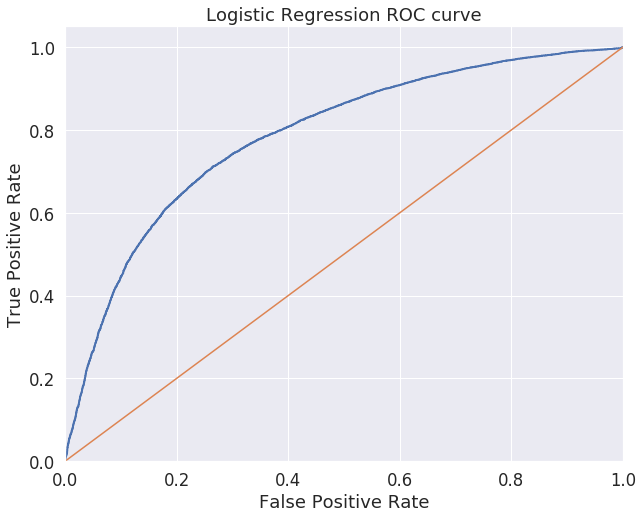

In [14]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC curve')
plt.show()

In [15]:
from xgboost import XGBClassifier

In [16]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', XGBClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7963303868912173+-0.0093374404758341


In [17]:
fscore, precision, recall = eval_model(y_test, y_score) 

In [18]:
classifier_dict["Model"].append("XGBClassifier")

In [19]:
classifier_dict["F-Score"].append(fscore)
classifier_dict["Precision"].append(precision)
classifier_dict["Recall"].append(recall)

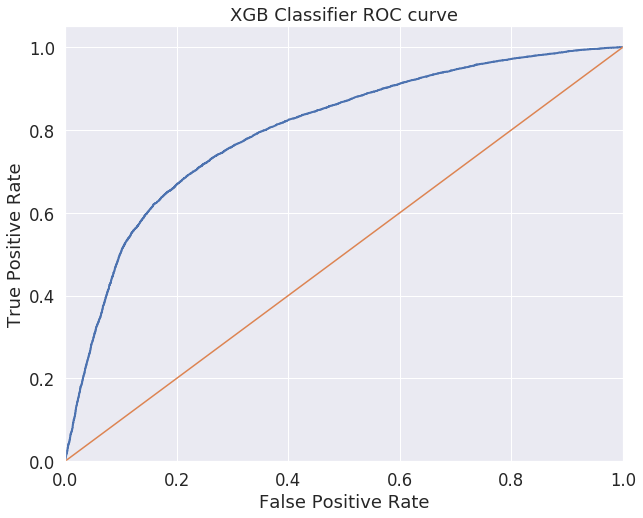

In [20]:
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier ROC curve')
plt.show()

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7732916746021321+-0.009817086235687897


In [23]:
fscore, precision, recall = eval_model(y_test, y_score)

In [24]:
classifier_dict["Model"].append("RandomForestClassifier")

In [25]:
classifier_dict["F-Score"].append(fscore)
classifier_dict["Precision"].append(precision)
classifier_dict["Recall"].append(recall)

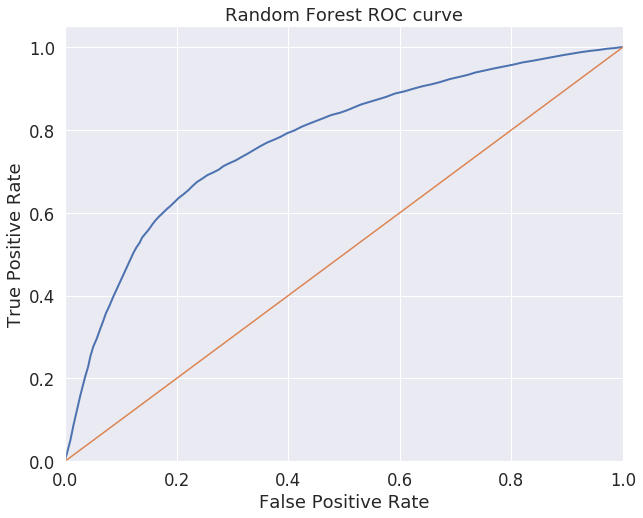

In [26]:
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC curve')
plt.show()

In [27]:
model_df = pd.DataFrame.from_dict(classifier_dict, orient='columns')

In [28]:
model_df.loc[:,].round(3)

,Model,F-Score,Precision,Recall
0,LigisticRegression,0.884,0.520,0.990
1,XGBClassifier,0.886,0.520,0.993
2,RandomForestClassifier,0.883,0.503,1.000


XGBClassifier немного лучше справляется с задачей распознавания двух классов. 